In [152]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [153]:
import numpy as np
import pandas as pd

In [154]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [155]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [156]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [157]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [158]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [159]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [160]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Design a query to retrieve the last 12 months of precipitation data and plot the results

In [161]:
# list columns of measurement table
from sqlalchemy import inspect
ins = inspect(engine)
columns = ins.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [162]:
# list columns of station table
columns = ins.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [163]:
# Calculate the date 1 year ago from the last data point in the database
last_date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for r in last_date_result:
    last_date = r
print(last_date)
dt1 = dt.datetime.strptime(last_date, "%Y-%m-%d")
query_date = dt1 - dt.timedelta(days=365) # 1 year ago    
print(query_date)

2017-08-23
2016-08-23 00:00:00


In [164]:
# Perform a query to retrieve the date and precipitation DATA
lastyears_data = session.query(Measurement.date, func.sum(Measurement.prcp)).\
   filter(Measurement.date > dt.datetime.date(query_date)).\
   group_by(Measurement.date)
#datetime.date(2016, 8, 23)

In [165]:
# Save the query results as a Pandas DataFrame and set the index to the date column
lastyears_data_df = pd.DataFrame(lastyears_data, columns=['date','prcp'])
lastyears_data_df.set_index('date', inplace=True)
lastyears_data_df.head()



,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


In [166]:
# Sort the dataframe by date
lastyears_data_df = lastyears_data_df.sort_values(["date"])
lastyears_data_df.head(10)

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
2016-08-29,1.46
2016-08-30,0.07
2016-08-31,3.18
2016-09-01,0.03


## note, the data here relects the sum of precipitation from all 9 stations and includes days when there was zero precipitatioon

<Figure size 1440x1280 with 0 Axes>

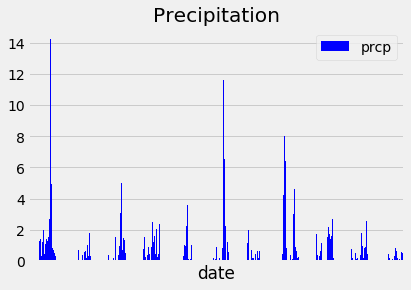

In [167]:
# Use Pandas Plotting with Matplotlib to plot the data
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
lastyears_data_df.plot(kind='bar', color='blue',
    title = 'Precipitation')
plt.xlabel("date")
plt.xticks([])
plt.rcParams["figure.figsize"]=(10,20)
plt.show()

![precipitation](Images/precipitation.png)

## note, the data here reflects the sum of precipitation from all 9 stations for the last yesr and includes days when there was zero precipitatioon

In [168]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyears_data_df.describe()

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


![describe](Images/describe.png)

In [169]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()


9

## note, the data below reflects all dates in the database, not just the last year

In [170]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station = session.query(Measurement.station, func.count(Measurement.prcp)).\
   group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc())
for row in count_by_station:
        print(row)


('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [171]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
highest_station_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == count_by_station[0][0])
highest_station_data_df = pd.DataFrame(highest_station_data)
highest_station_data_df.set_index('date', inplace=True)
print("for station " + count_by_station[0][0])
highest_station_data_df.describe()

for station USC00519281


,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


In [172]:
# Choose the station with the highest number of temperature observations.
count_by_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
   group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
for row in count_by_station:
        print(row)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [173]:
# Query the last 12 months of temperature observation data for this station
highest_station_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == count_by_station[0][0]).\
    filter(Measurement.date >= query_date)
highest_station_data_df = pd.DataFrame(highest_station_data)
highest_station_data_df.set_index('date', inplace=True)
highest_station_data_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


Text(0, 0.5, 'Frequency')

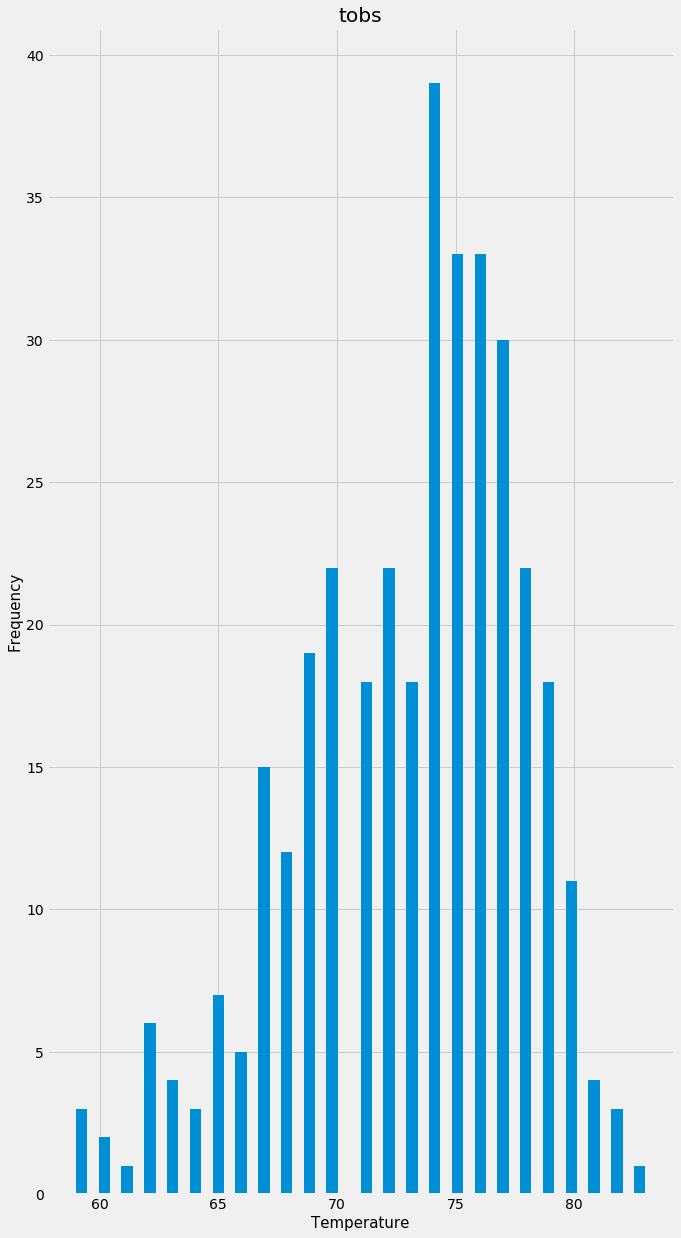

In [174]:
# plot the results as a histogram with bins = 50
highest_station_data_df.hist(column="tobs", bins=50)
plt.xlabel("Temperature",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

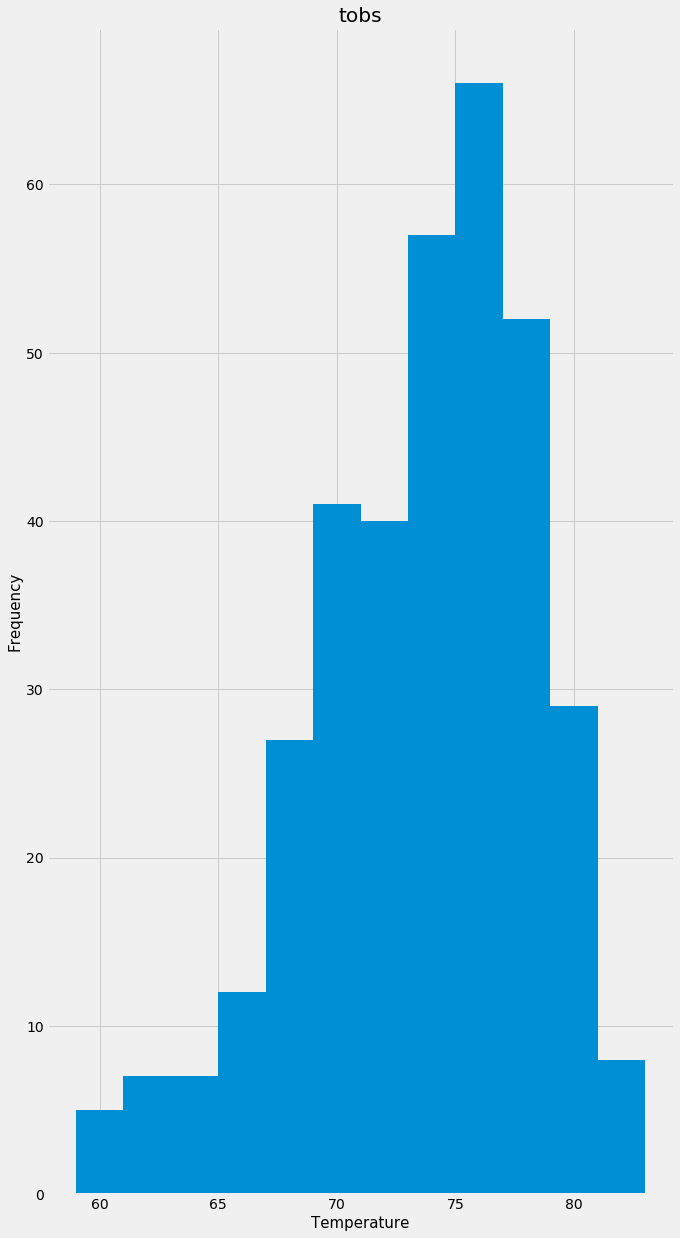

In [175]:
# plot the results as a histogram with bins = 12
highest_station_data_df.hist(column="tobs", bins=12)
plt.xlabel("Temperature",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

![precipitation](Images/station-histogram.png)

In [176]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


# The stuff below was not included under Step 1

In [177]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [178]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [179]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [180]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [181]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [182]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [183]:
# Plot the daily normals as an area plot with `stacked=False`


In [184]:
# this cell shows date/station combination in Measutement tsble is unique
data = session.query(Measurement.date, Measurement.station)
data_df = pd.DataFrame(data)
print(len(data_df))
df = data_df.groupby(['date', 'station'])
print(len(df))
df = data_df.groupby(['station'])
print(len(df))
df = data_df.groupby(['date'])
print(len(df))


19550
19550
9
2792


## Also, based on the previous cell, the most frequently reporting station missed 20 days of observations, 2772 vs. 2792 possible